In [1]:
using GpAbc, DifferentialEquations, Distances, Plots

# Rejection ABC using GaussProABC - estimating parameters

This notebook demonstrates how to perform simulation- and emulation-based rejection ABC using GaussProABC for parameter estimation of an ODE model.

Start by choosing some settings for ABC, the emulator and the toy, noise-free ODE system. There is also a wrapper function that returns the solution to the toy system for some given parameters and ODE solution options.

In [2]:
#
# ABC settings
#
n_var_params = 2
n_particles = 1000
threshold = 0.5
priors = [Distributions.Uniform(0., 5.), Distributions.Uniform(0., 5.)]
distance_metric = euclidean
progress_every = 1000

#
# Emulation settings
#
n_design_points = 100
batch_size = 1000
max_iter = 1000

#
# True parameters
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by DifferentialEquations
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]./(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

(::#1) (generic function with 1 method)

## Plot reference data

The reference data is the concentrations over time for the three species. Computed by solving the model with the true parameters.

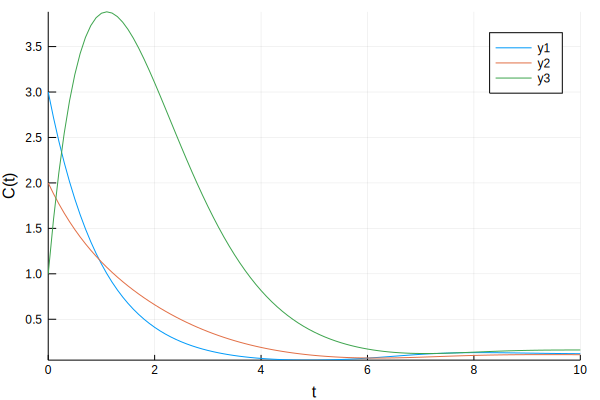

In [3]:
#
# Get reference data and plot it
#
reference_data = GeneReg(true_params, Tspan, x0, solver, saveat)
println("Got reference data")

plot(reference_data.t, transpose(hcat(reference_data.u...)), xlabel="t", ylabel="C(t)")


## Simulation-based rejection ABC

To perform rejection ABC, first construct an instance of one of either two objects: `SimulatedABCRejectionInput` or `EmulatedABCRejectionInput`.

The simulated version contains the number of accepted particles, acceptance threshold, priors, the distance metric and the simulator funciton. Note that this needs to be extended to include summary statistics.

The simulator function is user-defined and must to take the unknown parameters as a single argument and return the simluated trajectories.

After constructing the input object it is passed to `ABCrejection` with the reference (observed) data to perform rejection ABC.

In [4]:
#
# Simulation
#
simulator_function(var_params) = GeneReg(vcat(var_params, true_params[n_var_params+1:end]), Tspan, x0, solver, saveat)

sim_rej_input = SimulatedABCRejectionInput(n_var_params,
                        n_particles,
                        threshold,
                        priors,
                        distance_metric,
                        simulator_function)

sim_result = ABCrejection(sim_rej_input, reference_data, progress_every=progress_every)

2018-06-20T17:36:49.544 Accepted 14/1000 particles.
2018-06-20T17:36:49.675 Accepted 41/2000 particles.
2018-06-20T17:36:49.785 Accepted 68/3000 particles.
2018-06-20T17:36:49.895 Accepted 87/4000 particles.
2018-06-20T17:36:50.006 Accepted 115/5000 particles.
2018-06-20T17:36:50.119 Accepted 144/6000 particles.
2018-06-20T17:36:50.233 Accepted 164/7000 particles.
2018-06-20T17:36:50.348 Accepted 194/8000 particles.
2018-06-20T17:36:50.462 Accepted 221/9000 particles.
2018-06-20T17:36:50.573 Accepted 240/10000 particles.
2018-06-20T17:36:50.688 Accepted 262/11000 particles.
2018-06-20T17:36:50.803 Accepted 285/12000 particles.
2018-06-20T17:36:50.917 Accepted 308/13000 particles.
2018-06-20T17:36:51.031 Accepted 337/14000 particles.
2018-06-20T17:36:51.138 Accepted 365/15000 particles.
2018-06-20T17:36:51.249 Accepted 388/16000 particles.
2018-06-20T17:36:51.36 Accepted 410/17000 particles.
2018-06-20T17:36:51.475 Accepted 431/18000 particles.
2018-06-20T17:36:51.589 Accepted 448/19000

GpAbc.ABCRejectionOutput(2, 1000, 41630, 0.5, [1.42904 1.03473; 2.24971 0.942612; … ; 2.25863 0.962215; 1.30655 0.950319], [0.246655, 0.199105, 0.338825, 0.480588, 0.257054, 0.0797651, 0.308165, 0.249225, 0.275062, 0.493976  …  0.347293, 0.399687, 0.350405, 0.316792, 0.454397, 0.45901, 0.176449, 0.332309, 0.144916, 0.364647], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

## Emulation-based Rejection ABC

First train the emulator. This requires training inputs `X` and training outputs `y`, where `X` is an array with size (n_design_points, n_unknown_parameters) and `y` is an array with size (n_design_points).

The function `get_training_data` returns `X` and `y` in the correct format to be used with a `GPModel`.

Then train the model, plotting the design points and their distances.

Trained emulator


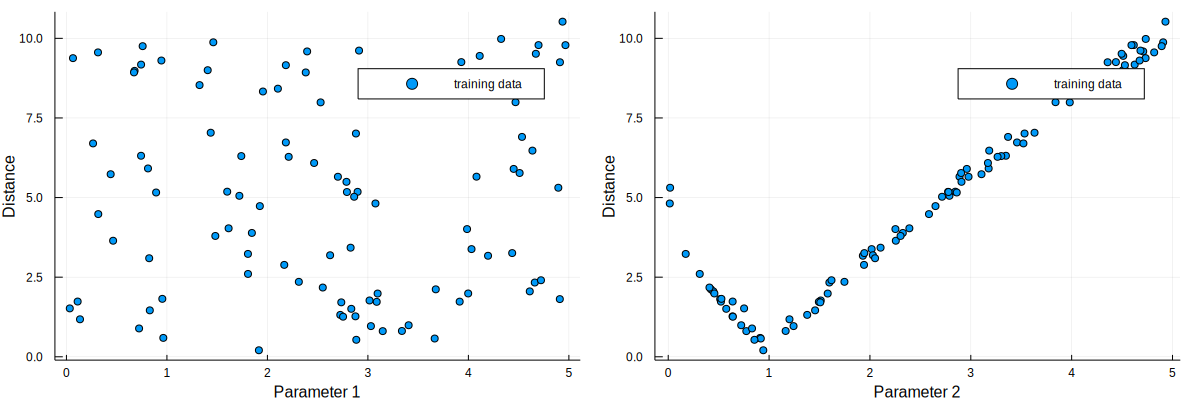

In [5]:
#
# Train the Emulator
#

#
# First prepare data for emulator - matrix X contains design ponts and y contains distances
#
function get_training_data(n_design_points,
  priors,
  simulator_function, distance_metric,
  reference_data)
    
  X = zeros(n_design_points, length(priors))
  y = zeros(n_design_points)  
  for i in 1:n_design_points
    dp = [rand(d) for d in priors]
    X[i,:] = dp
    y[i] = distance_metric(simulator_function(dp), reference_data)
  end
    
  return X, y
end

X, y = get_training_data(n_design_points, priors, simulator_function, distance_metric, reference_data)

#
# Train emulator - VARIANCE SEEMS SMALL
#
gpem = GPModel(training_x=X, training_y=y, kernel=SquaredExponentialArdKernel())
gp_train(gpem)

println("Trained emulator")

#
# Plot design points
#
plts = [scatter(X[:,idx], y, label="training data", xlabel="Parameter $idx", ylabel="Distance") for idx = 1:size(priors, 1)]
plot(plts..., size=(1200, 400))

The second parameter is easier to pick up using this distance metric and summary statistic than the first.

When creating an `EmulatedABCRejectionInput` object provide a function that returns the emulated distances rather than the `simulator_function` required in the simulation case. Also provide a batch size and a maximum number of iterations.

In [6]:
#
# Use the emulator for rejection ABC
#
function predict_distance(p::AbstractArray{Float64})
    result = gp_regression(p,gpem)[1]
    return result
end

emu_rej_input = EmulatedABCRejectionInput(n_var_params,  
  n_particles,
  threshold,
  priors,
  predict_distance,
  batch_size,
  max_iter)

emu_result = ABCrejection(emu_rej_input, reference_data, progress_every=5)

2018-06-20T17:37:22.785 Accepted 108/5000 particles (5 batches of size 1000).
2018-06-20T17:37:22.847 Accepted 248/10000 particles (10 batches of size 1000).
2018-06-20T17:37:22.902 Accepted 365/15000 particles (15 batches of size 1000).
2018-06-20T17:37:22.958 Accepted 501/20000 particles (20 batches of size 1000).
2018-06-20T17:37:23.007 Accepted 628/25000 particles (25 batches of size 1000).
2018-06-20T17:37:23.058 Accepted 767/30000 particles (30 batches of size 1000).
2018-06-20T17:37:23.111 Accepted 906/35000 particles (35 batches of size 1000).


GpAbc.ABCRejectionOutput(2, 1000, 39000, 0.5, [1.90297 0.982229; 2.53028 0.948388; … ; 3.04989 1.01172; 2.75623 1.09317], [0.243193, 0.287171, 0.289352, 0.279681, 0.297995, 0.282138, 0.292468, 0.363161, 0.289187, 0.347724  …  0.34364, 0.280289, 0.497991, 0.26322, 0.235935, 0.435132, 0.303885, 0.483002, 0.398394, 0.426158], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

# Comparing the resulting posteriors from simulation and emulation

They are similar and both center on the correct parameter values.

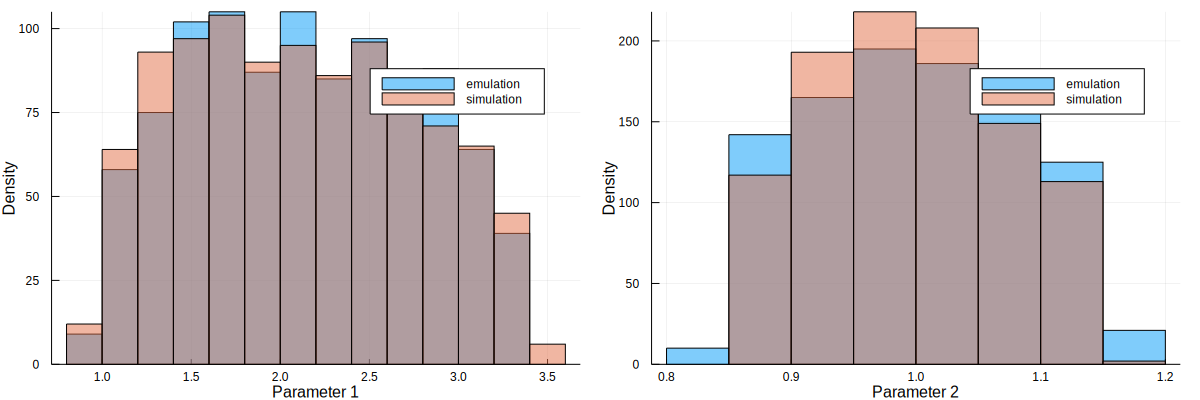

In [7]:
plts = Vector{Plots.Plot}(n_var_params)
for idx in 1:n_var_params
    plts[idx] = histogram([emu_result.population[:,idx] sim_result.population[:,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(1200, 400))

# ABC-SMC

In [8]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0]

3-element Array{Float64,1}:
 3.0
 2.0
 1.0

## Simulation-based ABC-SMC

In [9]:
sim_abcsmc_input = SimulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    distance_metric,
    simulator_function)

sim_abcsmc_res = ABCSMC(sim_abcsmc_input, reference_data)

2018-06-20T17:37:52.999 Accepted 323/1000 particles.
2018-06-20T17:37:53.111 Accepted 664/2000 particles.
2018-06-20T17:37:54.408 Accepted 573/1000 particles.
2018-06-20T17:37:55.407 Accepted 347/1000 particles.
2018-06-20T17:37:55.938 Accepted 676/2000 particles.


GpAbc.ABCSMCOutput(2, [1000, 1000, 1000], [2988, 1785, 2985], [3.0, 2.0, 1.0], Array{Float64,2}[[1.8975 1.52823; 1.08316 0.255411; … ; 2.91857 1.84512; 2.14164 1.45908], [3.53385 0.7055; 1.29215 0.634057; … ; 3.51592 1.23644; 3.5033 0.689818], [3.29796 1.17864; 3.75484 1.1334; … ; 2.76282 1.23745; 3.98713 0.791373]], Array{Float64,1}[[1.66647, 2.88266, 1.66399, 1.53261, 1.56323, 1.7909, 2.23554, 2.95377, 1.53047, 0.648739  …  1.70211, 0.836311, 1.95417, 1.24075, 2.74763, 2.04877, 2.19391, 0.898409, 2.71836, 1.48225], [1.05972, 1.37498, 1.53426, 1.65111, 1.22447, 1.20524, 1.91124, 0.627512, 1.88998, 1.67324  …  1.68112, 0.190124, 0.804381, 1.82007, 0.578923, 0.166357, 1.48689, 1.51384, 1.05423, 1.10979], [0.839372, 0.841897, 0.98703, 0.770968, 0.935505, 0.82919, 0.642346, 0.663129, 0.957884, 0.82122  …  0.8118, 0.827041, 0.646705, 0.443047, 0.780096, 0.957637, 0.575551, 0.938473, 0.892576, 0.861858]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00

## Emulation-based ABC-SMC

In [10]:
emu_abcsmc_input = EmulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    predict_distance,
    batch_size,
    max_iter)

emu_abcsmc_res = ABCSMC(emu_abcsmc_input, reference_data)

2018-06-20T17:38:03.014 Accepted 413/1000 particles.
2018-06-20T17:38:03.467 Accepted 857/2000 particles.
2018-06-20T17:38:04.045 Accepted 403/1000 particles.
2018-06-20T17:38:04.477 Accepted 849/2000 particles.


GpAbc.ABCSMCOutput(2, [1000, 1000, 1000], [3000, 2334, 2380], [3.0, 2.0, 1.0], Array{Float64,2}[[0.443321 1.07581; 1.35598 1.70699; … ; 3.44361 1.33156; 3.61614 0.973746], [2.56754 0.975866; 0.123016 0.944335; … ; 2.70414 1.54782; 2.73522 1.44263], [2.00944 0.956343; 1.81028 0.743783; … ; 0.360024 0.979015; 2.96989 0.902486]], Array{Float64,1}[[0.797211, 2.12934, 0.68036, 0.467517, 2.88908, 2.75469, 1.3994, 1.5095, 2.11376, 2.46221  …  0.782294, 0.660177, 2.59995, 1.65796, 2.2864, 2.55568, 0.315842, 1.76309, 1.37228, 0.580987], [0.277688, 1.07029, 1.26104, 1.99853, 0.807028, 1.60226, 0.839761, 0.751553, 0.274809, 1.56226  …  1.86669, 0.675773, 0.732224, 1.80214, 1.34022, 0.494565, 1.08313, 0.387933, 1.81871, 1.51572], [0.254024, 0.852286, 0.778602, 0.977165, 0.516691, 0.376104, 0.935419, 0.282971, 0.254096, 0.989049  …  0.901112, 0.519572, 0.744471, 0.52447, 0.850786, 0.896639, 0.980133, 0.243443, 0.853323, 0.421192]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,

## Compare the posteriors

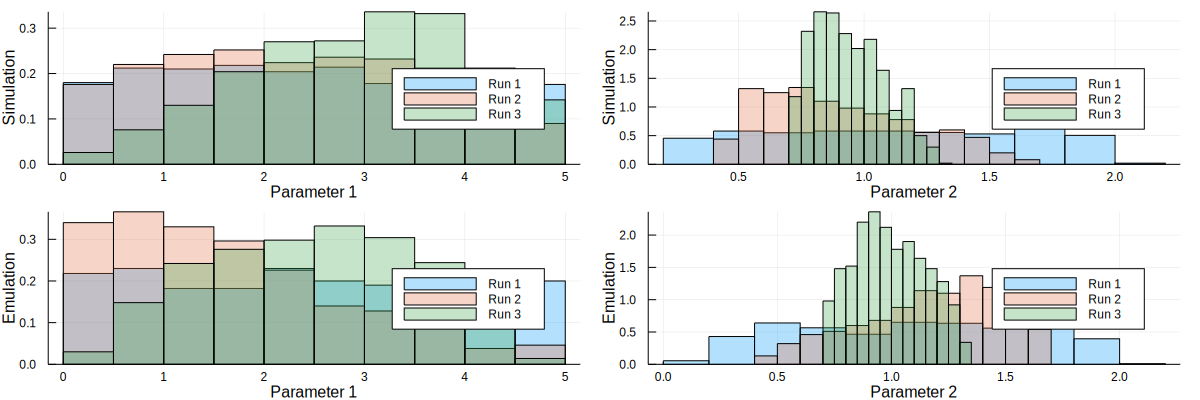

In [21]:
abcsmc_res = [sim_abcsmc_res, emu_abcsmc_res]
ylabels=["Simulation", "Emulation"]
plts = Vector{Plots.Plot}(n_var_params * 2)
idx = 1
for i in 1:2
    for j in 1:n_var_params
        hist_data = hcat([abcsmc_res[i].population[k][:,j] for k in 1:length(threshold_schedule)]...)
        labels = ["Run $k" for k in 1:length(threshold_schedule)]
        plts[idx] = histogram(hist_data, label=labels, fillalpha=0.3, xlabel="Parameter $j", ylabel=ylabels[i], normed=true)
        idx += 1
    end
end
plot(plts..., size=(1200, 400))


In [15]:
size(abcsmc_res[1].population[end])

(1000, 2)